# Quantum Harmonic Oscillator

In this notebook we'll solve the quantum harmonic oscillator with machine learning techniques.

The Hamiltonian of the oscillator is:

$$ H = \frac{1}{2m}p^2 + \frac{m \omega^2}{2}x^2 $$

According to the variational principle of quantum mechanics, for any wave function $|\psi>$, 

$$ < \psi | H | \psi > ~ \ge ~ E_0 $$

When substitued into the variational principle, we have:

$$ \int_{-\infty}^{\infty} \psi^*(x) H \psi(x) dx $$
$$ \int_{-\infty}^{\infty} \psi^*(x) [\frac{1}{2m}p^2 + \frac{m \omega^2}{2}x^2 ] \psi(x) dx$$

Subsituting $p = -i \hbar \frac{\partial}{\partial x}$ :
$$ \int_{-\infty}^{\infty} \psi^*(x) \frac{1}{2m}[- \hbar]^2 \frac{\partial^2}{\partial x ^2}   \psi dx + \int_{-\infty}^{\infty} \psi^* \frac{m \omega^2}{2}x^2  \psi(x) dx$$

$$ \frac{-\hbar^2}{2m} \int_{-\infty}^{\infty} \psi^*(x)  \frac{\partial^2}{\partial x ^2}   \psi dx + \frac{m \omega^2}{2} \int_{-\infty}^{\infty} \psi^* x^2  \psi(x) dx $$

To solve this numerically, let's integrate by parts to turn a second derivative into two first derivatives:
$$ < \psi | H | \psi > = \frac{m \omega^2}{2} \int_{-\infty}^{\infty} \psi^* x^2  \psi(x) dx - \frac{\hbar^2}{2m} \left[\psi^*(x)\frac{\partial \psi (x)}{\partial x}  \Biggr|_{-\infty}^{\infty}  - \int_{-\infty}^{\infty} \frac{\partial \psi^*(x)}{\partial x} \frac{\partial \psi(x)}{\partial x} dx \right] $$

The wavefunctions for the harmonic oscillator have to got to zero at $\pm \infty$, so the first term in the integration by parts can be dropped.  Then, the total integral to evaluate is:

$$ < \psi | H | \psi > = \frac{m \omega^2}{2} \int_{-\infty}^{\infty} \psi^* x^2  \psi(x) dx + \frac{\hbar^2}{2m}  \int_{-\infty}^{\infty} \frac{\partial \psi^*(x)}{\partial x} \frac{\partial \psi(x)}{\partial x} dx $$

We have assumed above that the wave functions are normalized, but with ou approximation scheme we won't have normalized wavefunctions.  In this case, let's add in the normalization ourselves:

$$ < \psi | H | \psi > = \frac{1}{N} \left[\frac{m \omega^2}{2} \int_{-\infty}^{\infty} \psi^* x^2  \psi(x) dx + \frac{\hbar^2}{2m}  \int_{-\infty}^{\infty} \frac{\partial \psi^*(x)}{\partial x} \frac{\partial \psi(x)}{\partial x} dx \right]$$
where 
$$ N = \int_{-\infty}^{\infty} \psi^*(x) \psi(x) dx $$

To solve this, and estimate the ground state energy of the system, we need to find a wave function and estimate these two integrals.

We will use a pytorch module to approximate our wavefunction, which we can then differentiate.  The requirements of this system are that:
- the wavefunction must be normalizable
- the wavefunction must go to zero at $\pm \infty$

In [1]:
import numpy
import torch
from matplotlib import pyplot as plt

In [2]:
omega = 1.0
hbar  = 1.0
M     = 1
delta = 0.5

In [26]:
class Wavefunction(torch.nn.Module):
    
    def __init__(self):
        torch.nn.Module.__init__(self)
        
#         self.layer1 = torch.nn.Linear(1,64)
#         self.layer2 = torch.nn.Linear(64, 1)
    
        self.const  = torch.nn.Parameter(torch.tensor(0.1), requires_grad=True)
        self.linear = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.quad   = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)

        self.norm   = torch.Tensor([1.0])
    
        self.exponent = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)


    def forward(self, inputs):
        x = inputs
#         x = self.layer1(x)
#         x = torch.sigmoid(x)
#         x = self.layer2(x)
    
        poly = self.const + self.linear * x + self.quad * x**2

        # Multiply by a factor to enforce normalization and boundary conditions:
        # Note the exponent is within the power of 2 to make it's sign irrelevant
        x = self.norm *  poly * torch.exp(- 0.5*(self.exponent * inputs) **2)
        return x
    
    def update_normalization(self, inputs):
        # Inputs is expected to be a range of parameters along an x axis.
        
        value = self.forward(inputs)
        N = value ** 2
        
        delta = inputs[1]-inputs[0]
        
        N = torch.sum(N) * delta
        
        self.norm = 1/torch.sqrt(N)
        
        # The normalization condition is that the integral of the wavefunction squared
        # should be equal to 1 (probability sums to 1.)
        
        return
    
    def analytic_derivative(self, inputs):
        
        poly = self.const + self.linear * x + self.quad * x**2
        poly_prime = self.linear + 2 * self.quad * inputs
        exp = torch.exp(- 0.5*(self.exponent * inputs) **2)
        
        res = exp * (-inputs) *poly + poly_prime * exp
        
        return self.norm * res
    
    def zero_grad(self):
        """Sets gradients of all model parameters to zero."""
        for p in self.parameters():
            if p.grad is not None:
                p.grad.data.zero_()

In [27]:
w = Wavefunction()


Let's create a test vector to see what the wavefunction looks like so far:

In [28]:
_x = numpy.arange(-20, 20, 0.05, dtype=numpy.float32)
print(_x.shape)

x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)
print(x.shape)


(800,)
torch.Size([800])


In [29]:
val = w(x)


In [30]:

torch.sum(val).backward()

In [31]:
print(torch.max(x.grad - w.analytic_derivative(x)))

tensor(3.7253e-09, grad_fn=<MaxBackward1>)


The shaping scheme above is a bit artificial but it makes each input into the wavefunction approximator a "batch".

In [32]:
w.update_normalization(x)
print(w.norm)
psi = w(x)

tensor(7.5113, grad_fn=<MulBackward0>)


To trigger torch to compute the derivative on all X, we need a scalar.  Sumation has a derivative of 1 for every object being summed and therefore we can use it as a proxy:

In [33]:
x.grad.zero_()
w.zero_grad()
torch.sum(psi).backward(retain_graph=True)

In [34]:
autograd = x.grad
analytic = w.analytic_derivative(x)

We also have the derivative of our wave function with respect to it's parameters, differentiating the sum.

Let's plot the wave function and it's 

In [35]:
list(w.parameters())

[Parameter containing:
 tensor(0.1000, requires_grad=True), Parameter containing:
 tensor(0., requires_grad=True), Parameter containing:
 tensor(0., requires_grad=True), Parameter containing:
 tensor(1., requires_grad=True)]

In [36]:
w.exponent

Parameter containing:
tensor(1., requires_grad=True)

Let's look at our function:

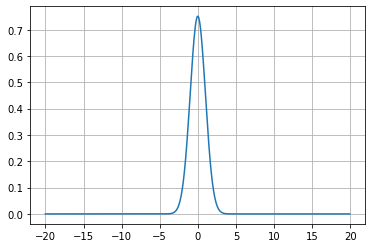

In [37]:
x_numpy = x.detach().numpy()
psi_numpy = psi.detach().numpy()

plt.plot(x_numpy, psi_numpy)
plt.grid(True)
plt.show()

Right now, it just looks like a gaussian which makes sense since that is the normalization factor.  Let's compute the normalization:

In [38]:
def normalization(wavefunction, inputs):
    return torch.sum(wavefunction(inputs) ** 2) * delta

In [39]:
norm = normalization(w, x)
print(norm)

tensor(2.0000, grad_fn=<MulBackward0>)


Now we can compute the other terms in the hamiltonian:

In [40]:
def potential_energy(wavefunction, inputs, k):
    temp = 0.5*(M * omega **2) * wavefunction(inputs)**2 * inputs**2
    return torch.sum(temp) * delta

In [41]:
pe = potential_energy(w, x, k=1)

In [42]:
def kinetic_energy(wavefunction_prime,):
    return (hbar**2 / (2 *M)) * torch.sum(wavefunction_prime**2) * delta

In [43]:
ke = kinetic_energy(x.grad)

Therefore, the computed energy for this wavefunction is:

In [44]:
energy = (1/norm) * ( pe +  ke)

In [45]:
print(energy)

tensor(7090.4316, grad_fn=<MulBackward0>)


The harmonic oscillator has energy levels of:
$$ E_n = \hbar \omega ( n + \frac{1}{2} ) $$
and so the ground state is $\hbar \omega / 2$. For this example, with $\hbar = 1$ and $\omega = 1$, we expect the estimate of the energy to be greater than or equal to 1/2.  Looks good above!

## Optimizing the wave function to find the ground state

In the above, we used the autograd functionality to compute the expectation value of energy of a wavefunction for the harmonic oscillator.  But, now we will use autograd again to compute the derivative of the energy with respect to the wavefunction's parameters, and optimize the parameters to update the wave function.

In [46]:
def integrate(tensor, step_size):
    return torch.sum(tensor) * step_size


def energy_computation(wavefunction, inputs, step_size):
    # This function takes the inputs (assumed to be a range of real value parameters)
    # And computes the expectation value of the energy.
    w_of_x = wavefunction(inputs)
    
    # Sum the wavefunction and call backwards to get the derivative of it with respect to x:
    grad_catalyst = torch.sum(w_of_x)
    grad_catalyst.backward(retain_graph = True)
    
    
    w_prime_dx = inputs.grad
#     w_prime_dx = w.analytic_derivative(inputs)
    
    # Now we can compute integrals:
    normalization = integrate(w_of_x**2, step_size)
    
    pe = (0.5 * M * omega**2 ) * integrate(w_of_x**2 * inputs**2, step_size)
    
    ke = (hbar**2 / (2 *M)) * integrate(w_prime_dx**2, step_size)
    
#     print()
#     print("pe: ", pe)
#     print("ke: ", ke)
#     print("norm: ", normalization)
#     print()

    
    energy = (pe + ke) / normalization
    
    return energy

In [47]:
def training_step(wavefunction, optimizer, delta):
    optimizer.zero_grad()
    _x = numpy.arange(-10, 10, delta, dtype=numpy.float32)
    _x = _x.reshape((_x.shape[0], 1))

    x = torch.autograd.Variable(torch.tensor(_x), requires_grad = True)

    energy = energy_computation(wavefunction, x, delta)
    w.zero_grad()
    
    energy.backward(retain_graph=True)
#     if i % 100 == 0: print(energy)
    optimizer.step()
    
    w.update_normalization(x.detach())

#     print("Const: ", w.const.data)
#     print("Linear: ", w.linear.data)
#     print("Quad: ", w.quad.data)
#     print("Exponent: ", w.exponent.data)

    return  energy



In [48]:
w = Wavefunction()
delta = 0.1

optimizer = torch.optim.Adam(w.parameters(),lr=0.01, weight_decay=0)

for i in range(5000):
    energy = training_step(w, optimizer, delta)
    if i % 100 == 0: print(energy)
    
    
    
    

tensor(0.5000, grad_fn=<DivBackward0>)
tensor(0.6045, grad_fn=<DivBackward0>)
tensor(0.6076, grad_fn=<DivBackward0>)
tensor(0.6097, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

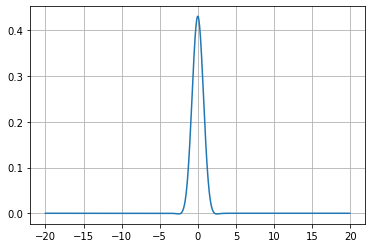

In [49]:
training_step(w, optimizer, delta)

x_numpy = x.detach().numpy()
psi_numpy = w(x).detach().numpy()

plt.plot(x_numpy, psi_numpy)
plt.grid(True)
plt.show()

In [50]:
print(w.const)
print(w.linear)
print(w.quad)
print(w.norm)




Parameter containing:
tensor(0.8694, requires_grad=True)
Parameter containing:
tensor(-0.0015, requires_grad=True)
Parameter containing:
tensor(-0.1768, requires_grad=True)
tensor([0.4951], grad_fn=<MulBackward0>)


In [ ]:
import scipy

In [ ]:
import scipy.integrate as integrate

In [ ]:
integrate(lambda x: w(torch.tensor(x))) 